In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# load python functions and modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# set user directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
lvl1path = '/Volumes/miri_mrs_data/FM_MRS/'
lvl2path = workDir+'FM_data/LVL2/'
cdpDir   = workDir+'cdp_data/'

**Let's load the LVL1 data**

In [5]:
# Get LVL1 data
sci_exp_filename,ignore_bkg   = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl1path,'1A',etalon='ET1A',output='filename')
sci_exp_hdu   = fits.open(sci_exp_filename.replace('_LVL2',''))
sci_exp_ramp  = (sci_exp_hdu[0].data).astype('float')

#-- print header 
# print(repr(sci_exp_hdu[0].header))

In [6]:
nints = sci_exp_hdu[0].header['NINT']
ngroups = sci_exp_hdu[0].header['NGROUP']
frame_delta_time = sci_exp_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('LVL1 data shape: {}'.format(sci_exp_ramp.shape))

Number of integrations: 4
Number of groups/frames per integration: 24
LVL1 data shape: (96, 1280, 1032)


**Plot MIRI ramp image**

<IPython.core.display.Javascript object>


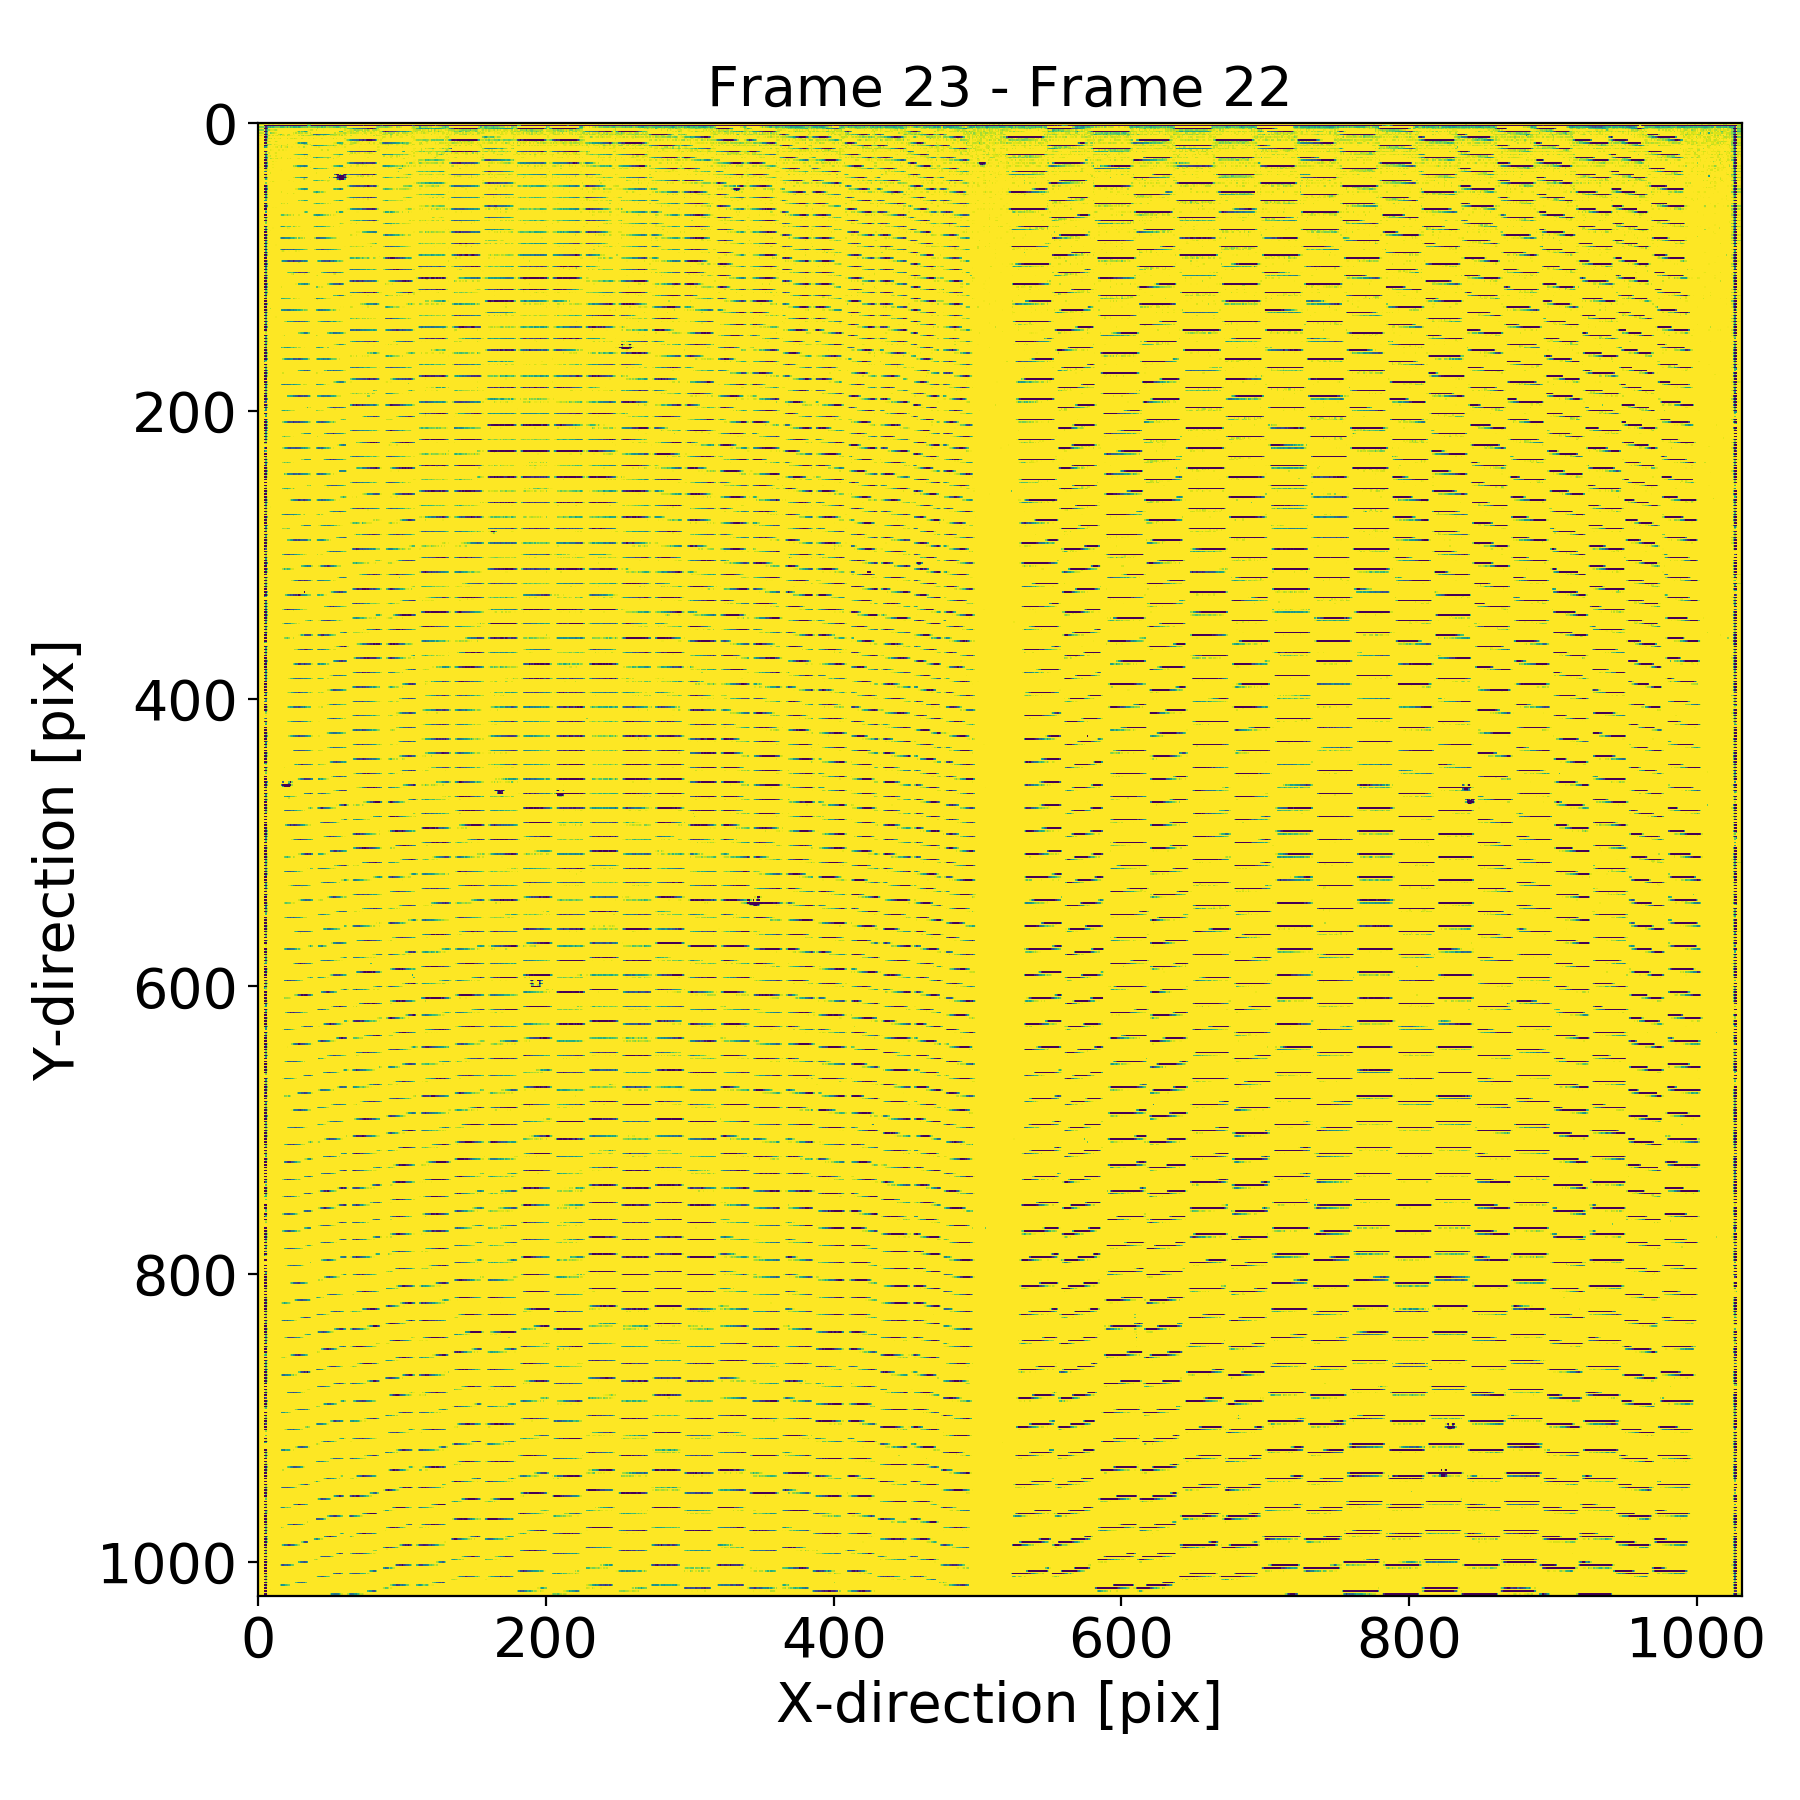

<IPython.core.display.Javascript object>


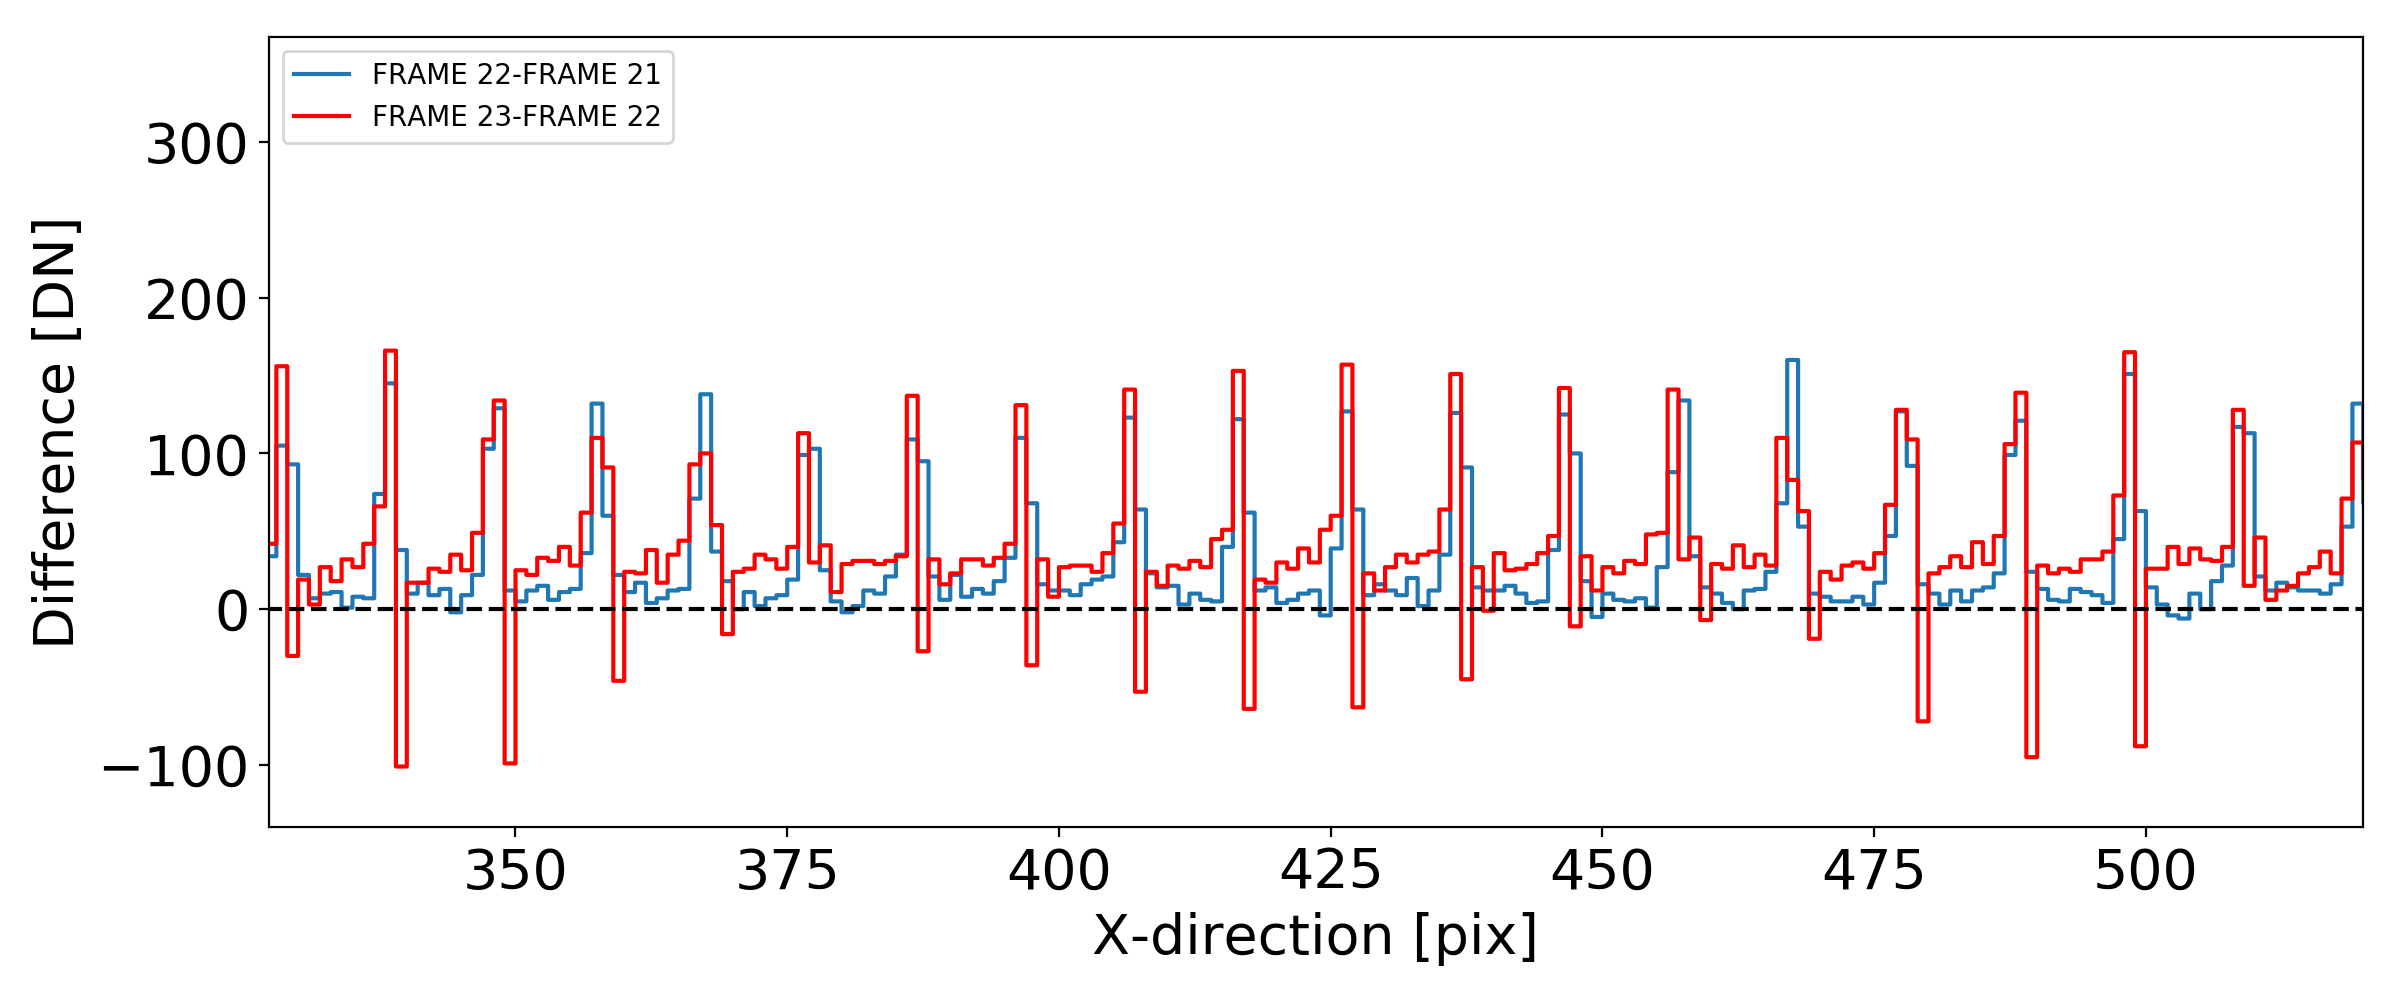

In [14]:
plt.figure(figsize=(9,9))
plt.title('Frame {} - Frame {}'.format(ngroups-1,ngroups-2))
plt.imshow(sci_exp_ramp[ngroups-1,:1024,:]-sci_exp_ramp[ngroups-2,:1024,:],vmin=-100,vmax=10)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

d2cMapDir = workDir+'notebooks/distortionMaps/'
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr10pc'.format('2A'),path=d2cMapDir)
ypos,xpos = funcs.detpixel_trace('2A',d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
ypos,xpos = np.arange(1024), (np.ones(1024)*120).astype(int)

plt.figure(figsize=(12,5))
plt.step(np.arange(len(ypos)),(sci_exp_ramp[ngroups-2,ypos,xpos]-sci_exp_ramp[ngroups-3,ypos,xpos]),zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-2,ngroups-3))
plt.step(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos],'r',zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-1,ngroups-2))
plt.hlines(0,0,1024,'k',linestyle='dashed',zorder=1)
plt.legend(loc='upper left',fontsize=10)
plt.xlabel('X-direction [pix]')
plt.ylabel('Difference [DN]')
plt.tight_layout()

**Let's look at the integration ramps for one pixel**

<IPython.core.display.Javascript object>


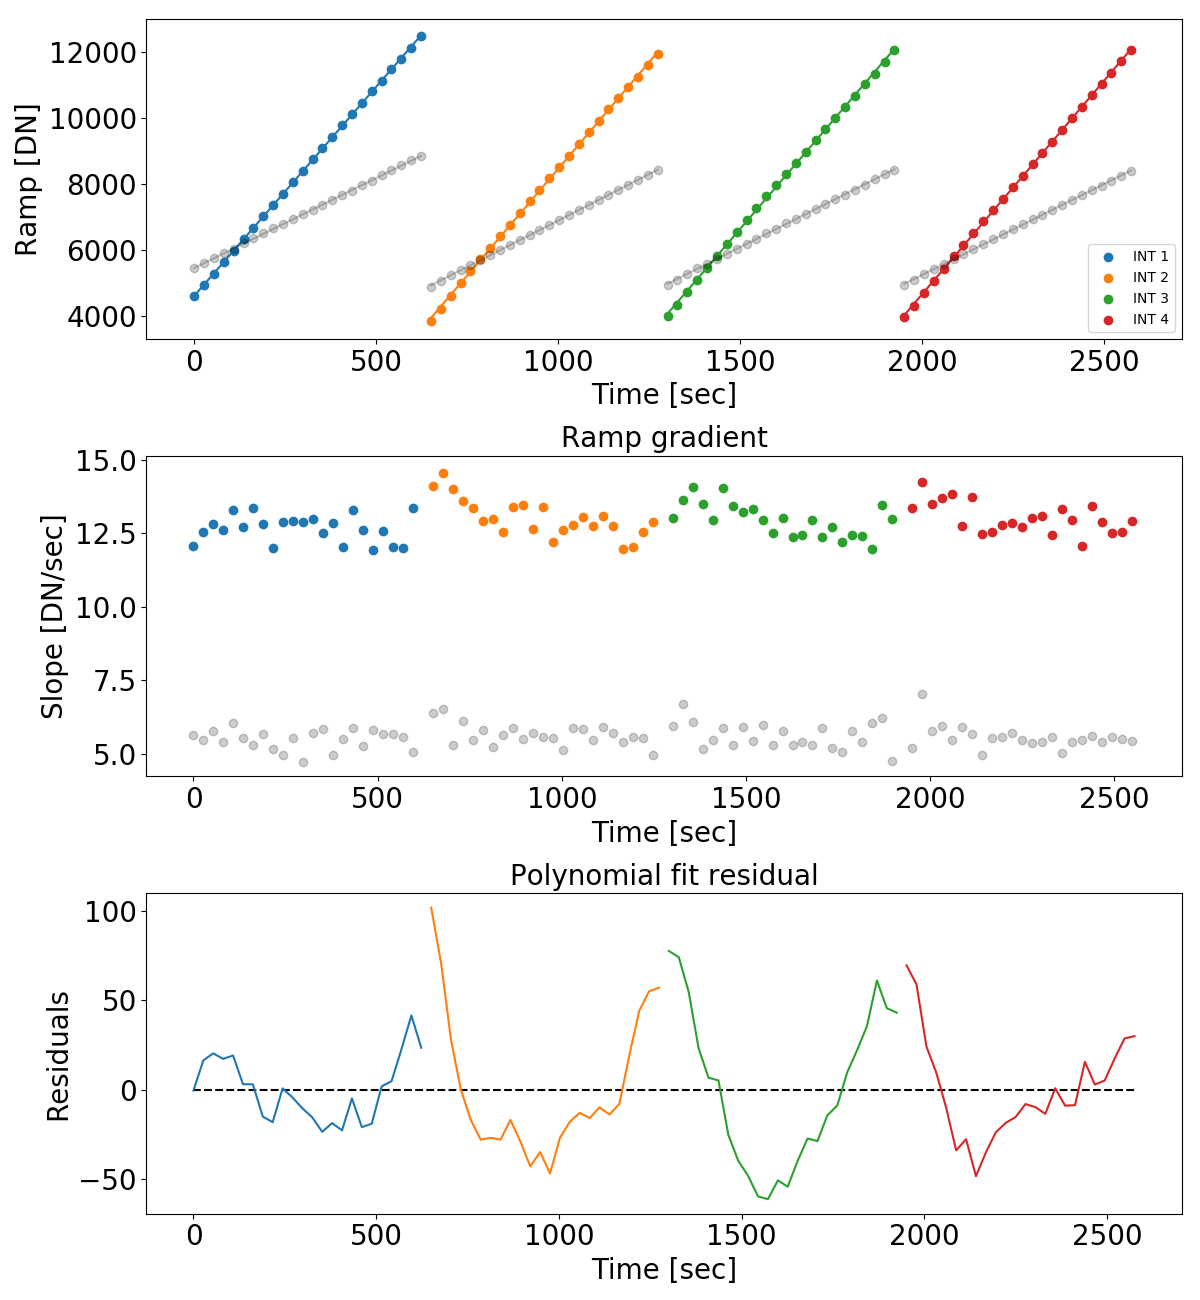

Determined slopes per integration: [12.69, 12.95, 12.89, 12.96] DN/sec
Determined slopes per integration (excluding last frame): [12.7, 12.97, 12.91, 12.97] DN/sec


In [7]:
ypos,xpos = 39,563
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes,slopes_minus_last_frame = [],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    
    xdata2  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata2  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos-1,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly)
    popt_minus_last_frame = np.polyfit(xdata[:-1],ydata[:-1],n_poly)
    poly = np.poly1d(popt)
    
    popt2 = np.polyfit(xdata2,ydata2,n_poly)
    poly2 = np.poly1d(popt2)
    
    slopes.append(round(popt[0],2))
    slopes_minus_last_frame.append(round(popt_minus_last_frame[0],2))
    
    residuals = poly(xdata)-ydata

    axs[0].plot(xdata,poly(xdata))
    axs[0].scatter(xdata,ydata,label='INT {}'.format(i+1))
    axs[0].plot(xdata2,poly2(xdata2),'k',alpha=0.2)
    axs[0].plot(xdata2,ydata2,'ko',alpha=0.2)
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='lower right',fontsize=10)
    axs[1].set_title('Ramp gradient')
    axs[1].scatter(xdata[:-1],np.diff(ydata)/frame_delta_time)
    axs[1].plot(xdata2[:-1],np.diff(ydata2)/frame_delta_time,'ko',alpha=0.2)
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals)
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration: {} DN/sec'.format(slopes))
print ('Determined slopes per integration (excluding last frame): {} DN/sec'.format(slopes_minus_last_frame))